## Debugging and testing ML pipeline

In [1]:
import time
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns
import networkx as nx

### Load json file in a dataframe

In [2]:
# paths
path_to_json_file = os.path.abspath('../data/json/')

# json file
json_file = '/all_parsed_data_json' #name json file  
file = '{}{}.json'.format(path_to_json_file, json_file)

In [3]:
# load json file
df = pd.read_json(file)

In [4]:
# print(df.memory_usage(deep=True))
# df.info(verbose=True)

In [5]:
df.head()

,nct_id,study_first_submitted,source,brief_title,overall_status,verification_date,study_type,study_first_posted,last_update_submitted,last_update_posted,...,detailed_description/textblock,brief_summary/textblock,location/facility/address/city,location/facility/address/country,location/facility/address/zip,sponsors/lead_sponsor/agency,sponsors/lead_sponsor/agency_class,study_design_info/allocation,study_design_info/intervention_model,study_design_info/primary_purpose
0,NCT00391586,"October 23, 2006",New Mexico Cancer Care Alliance,Erlotinib and Standard Platinum-Based Chemothe...,Terminated,August 2015,Interventional,"October 24, 2006","August 14, 2015","August 17, 2015",...,\n To compare the activities (the progres...,\n This study was conducted to compare th...,Albuquerque,United States,87102,New Mexico Cancer Care Alliance,Other,None,Single Group Assignment,Treatment
1,NCT03472664,"March 12, 2018",Wake Forest University Health Sciences,Brain Energy for Amyloid Transformation in Alz...,Recruiting,July 2018,Interventional,"March 21, 2018","July 30, 2018","August 1, 2018",...,\n This study will examine the effects of...,\n The Brain Energy for Amyloid Transform...,Winston-Salem,United States,27157,Wake Forest University Health Sciences,Other,Randomized,Parallel Assignment,Treatment
10,NCT01009658,"November 6, 2009",Gunma University,MSG and Gastrointestinal Motility,Completed,March 2015,Interventional,"November 9, 2009","March 25, 2015","March 26, 2015",...,\n Amino acids such as monosodium glutama...,\n The purpose of this study is to clarif...,Maebashi,Japan,3718511,Gunma University,Other,Randomized,Crossover Assignment,Basic Science
100,NCT03184311,"June 2, 2017","Cantonal Hosptal, Baselland",High-intensity Interval Training in Heart Fail...,Not yet recruiting,June 2017,Interventional,"June 12, 2017","June 9, 2017","June 12, 2017",...,\n Heart failure (HF) with preserved ejec...,\n This study investigates the effects of...,None,None,None,"Cantonal Hosptal, Baselland",Other,Randomized,Parallel Assignment,Treatment
1000,NCT00093301,"October 5, 2004",Wentworth Area Health Services,Levosimendan Versus Dobutamine in Shock Patients,Unknown status,December 2011,Interventional,"October 7, 2004","June 23, 2005","June 24, 2005",...,None,\n The purpose of the study is to compare...,Penrith,Australia,2750,Wentworth Area Health Services,Other,Randomized,Parallel Assignment,Treatment


## df setup
- Change data types & optimize memory usage
- Extract year
- Clean /n in text

In [6]:
# Change data types: Dates
columns_dates = ['study_first_submitted', 'study_first_posted', 'last_update_submitted', 'last_update_posted', 'verification_date']
for col in columns_dates:
    df[col] = df[col].astype('datetime64')
        

In [7]:
# # check
# for i in columns_dates:
#     print(df[i].dtypes)

In [8]:
# Extract year 
df['year_submitted'] = df['study_first_submitted'].dt.year
df['year_last_updated'] = df['last_update_submitted'].dt.year

In [9]:
# Remove /n
df = df.replace(r'\n',' ', regex=True)

In [10]:
#check dataset
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_columns', 500)
# df.sample(1)

In [11]:
# Put all texts in a single column
df['all_text'] = df['source'] + df['brief_title'] + df['condition'] + df['condition_browse/mesh_term'] + df['intervention_browse/mesh_term'] + df['detailed_description/textblock'] + df['brief_summary/textblock']
df['all_text'] = df['all_text'].str.lower()
df['all_text'][0]

'new mexico cancer care allianceerlotinib and standard platinum-based chemotherapy for newly diagnosed, advanced non-small cell carcinoma of the lungcarcinoma, non-small-cell lungcarcinomapaclitaxel       to compare the activities (the progression-free survival, the incidence and severity of       toxicities, and reversibility of toxicities) of erlotinib to that of platinum-based therapy       in nsclc. a sequential therapy design has been chosen such that all patients will receive any       potential benefits of both platinum-based and erlotinib therapy, without compromising       survival by denying anyone potential therapy. with this design, progression-free survival       will be tracked by treatment received. however, data will be generated which will show the       safety and efficacy of erlotinib in the frontline setting (alone and with historical       comparison to platinum-based therapy), as well as the potential safety and activity of       platinum-based therapy in the "sec

### Basic analysis

In [12]:
# Plot variables plt
blue = '#3298D0'
base_color = ['#3298D0', '#d7191c', '#ffffbf']
plot_size = (16, 12)

In [13]:
# Plot variables sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "arial"

(1998, 2020)

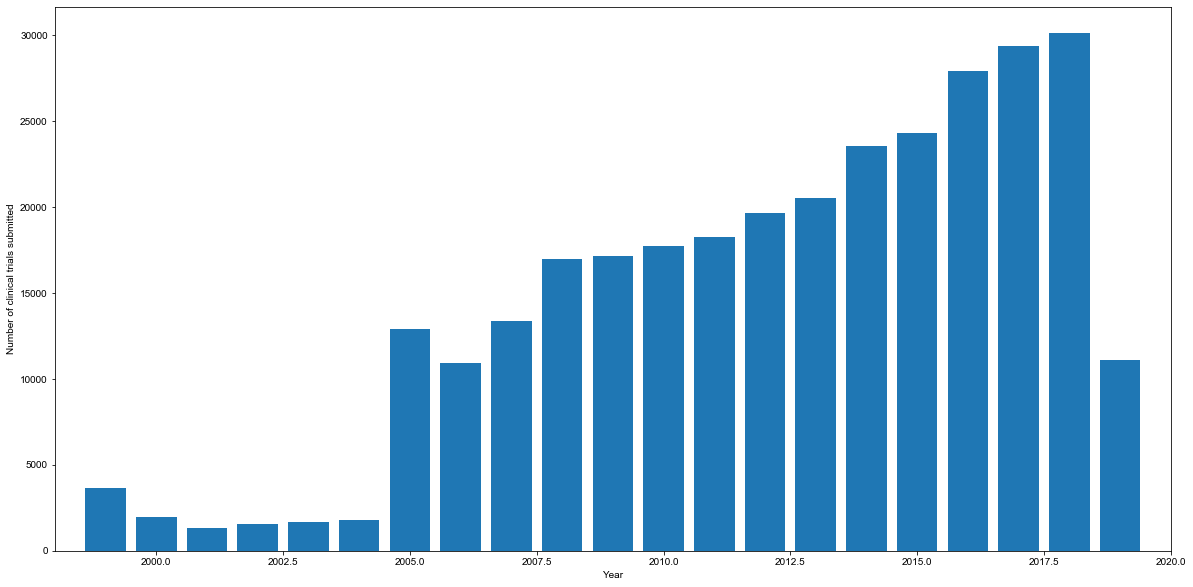

In [14]:
#trials per year -matplotlib
trials_per_year = df.groupby('year_submitted').nct_id.count()

plt.bar(trials_per_year.index, trials_per_year)
plt.xlabel('Year')
plt.ylabel('Number of clinical trials submitted')
plt.xlim(1998, 2020)

In [15]:
# group by two groups: year submitted, agency class
trials_year_status = df.groupby(['year_submitted','sponsors/lead_sponsor/agency_class']).nct_id.count()
trials_year_status['total'] = trials_year_status.sum()
trials_year_status.head()

year_submitted  sponsors/lead_sponsor/agency_class
1999            Industry                               517
                NIH                                   1586
                Other                                 1527
                U.S. Fed                                15
2000            Industry                                98
Name: nct_id, dtype: int64

In [16]:
# group by sponsor total -sns
sponsor = df.groupby(['sponsors/lead_sponsor/agency_class']).nct_id.count()
sponsor['total'] = sponsor.sum()
sponsor = pd.Series.to_frame(sponsor)

In [17]:
#add percentage
sponsor ['percentage'] = round(sponsor.nct_id / sponsor.nct_id.total * 100)

/Users/cms/Sites/env/haden/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


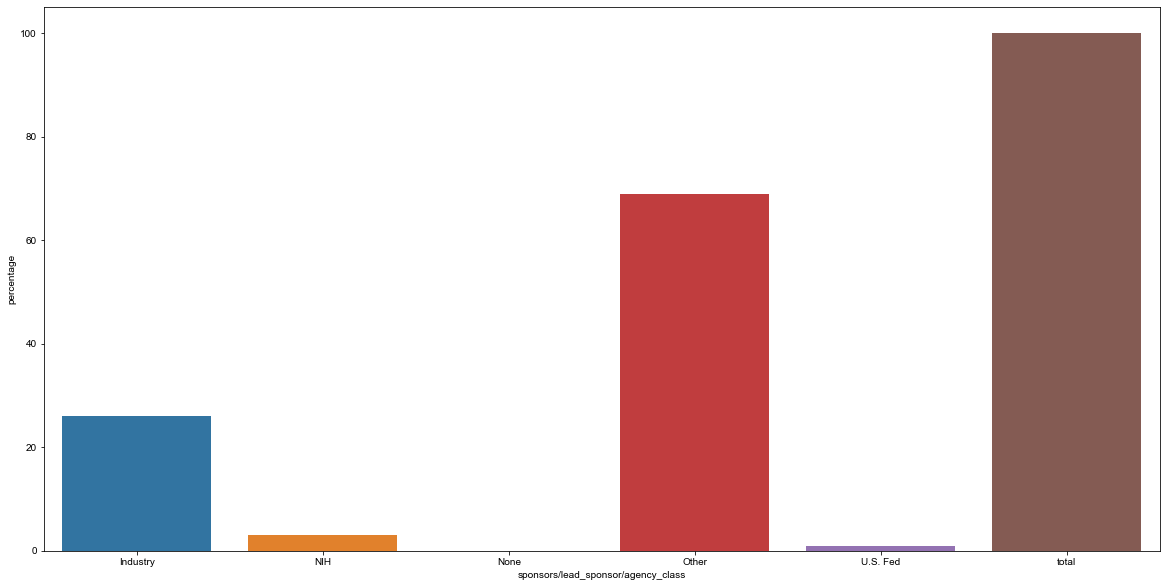

In [18]:
sponsor.loc[['nct_id', 'total']]
sns.barplot(x=sponsor.index, y=sponsor.percentage, data=sponsor)

## Conditions & mesh terms exploration

In [20]:
# Most frequent conditions
conditions = df.groupby('condition').nct_id.count()
conditions = pd.Series.to_frame(conditions)
conditions.sort_values('nct_id', ascending=False).head(10)

,nct_id
condition,
Healthy,6546
Breast Cancer,4609
Obesity,3039
HIV Infections,2469
Asthma,2454
Prostate Cancer,2386
Hypertension,1996
Schizophrenia,1964
Coronary Artery Disease,1830


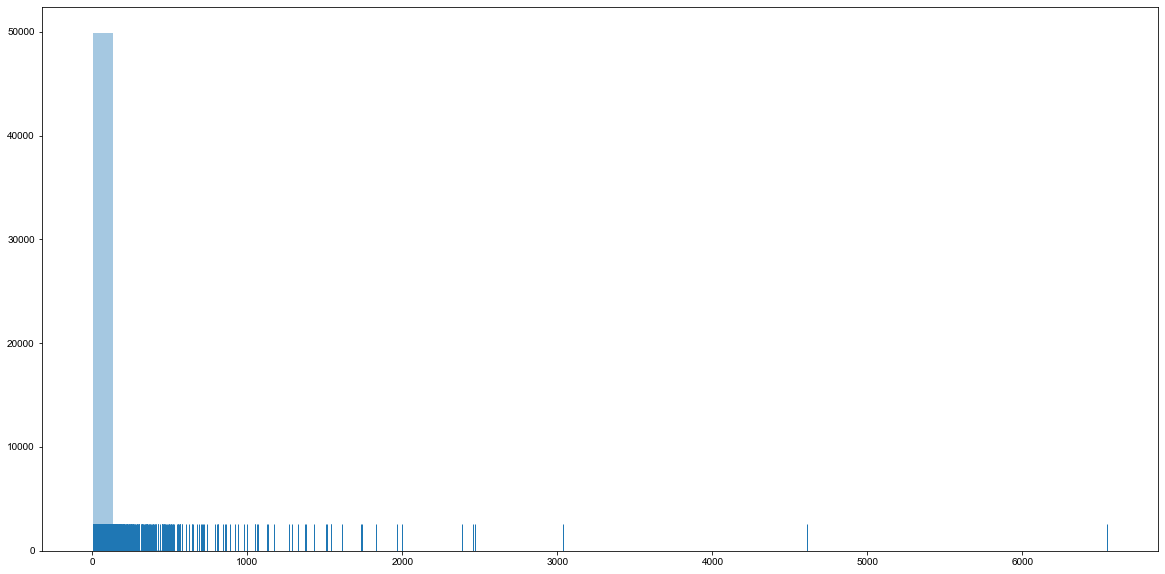

In [21]:
# histogram
sns.distplot(conditions, kde=False, rug=True)

In [22]:
mesh_term = df.groupby('condition_browse/mesh_term', as_index=False).nct_id.count()
mesh_term.sort_values('nct_id', ascending=False).head(10)

,condition_browse/mesh_term,nct_id
1573,None,58494
576,Diabetes Mellitus,9102
281,Breast Neoplasms,6399
2157,Syndrome,6102
598,Disease,4931
323,Carcinoma,4660
1327,Lymphoma,4303
1312,Lung Neoplasms,3956
1090,Hypertension,3740
1155,Infection,3649


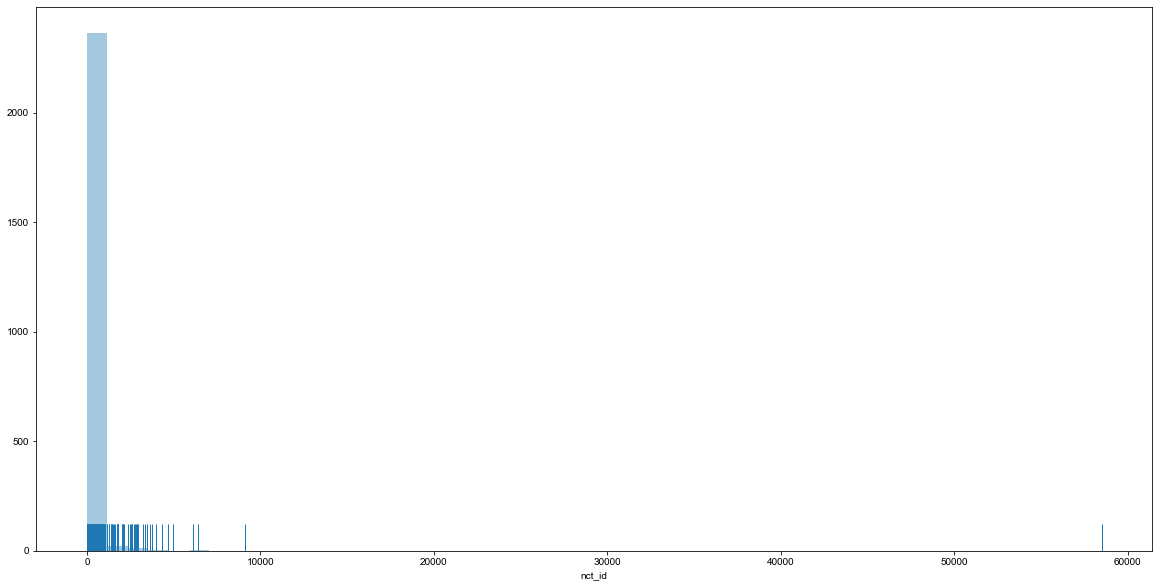

In [23]:
#histogram
sns.distplot(mesh_term.nct_id, kde=False, rug=True)

In [24]:
interventions = df.groupby('intervention_browse/mesh_term').nct_id.count()
interventions = pd.Series.to_frame(interventions)
interventions.sort_values('nct_id', ascending=False).head(10)

,nct_id
intervention_browse/mesh_term,
None,169063
Vaccines,5632
Insulin,2858
Paclitaxel,2741
Vitamins,2439
Anesthetics,2392
Pharmaceutical Solutions,2242
Cyclophosphamide,2039
Cisplatin,2033


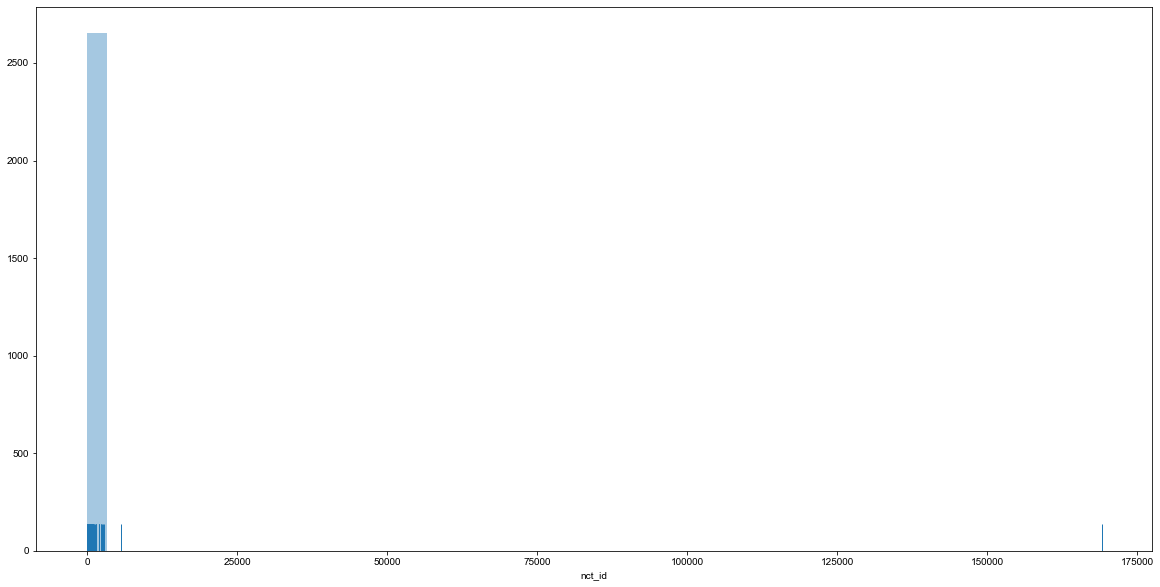

In [25]:
#histogram
sns.distplot(interventions.nct_id, kde=False, rug=True)

In [26]:
print(len(mesh_term))
print(len(conditions))
print(len(interventions))

2411
50164
2655


## Pandas simple search function

In [27]:
# Full search function
def full_search_pandas(column, term, df):
    #search term
    term_upper = term.upper()
    term_capital = term.capitalize()
    term_lower = term.lower()
    
    try:
        term = df[(df[column].str.contains(term_upper, regex=False)) | (df[column].str.contains(term_capital, regex=False)) | (df[column].str.contains(term_lower, regex=False))]

        # Full context for term searched
        print('Unique conditions {}'.format(term.condition.nunique()))
        print('Unique condition/mesh_terms: {}'.format(term['condition_browse/mesh_term'].nunique()))
        print('Unique interventon/mesh_terms: {}'.format(term['intervention_browse/mesh_term'].nunique()))
        print('Total number of studies: {}'.format(len(term)))

        #Chart: term over years
        sns.countplot(x="year_submitted", color='lightcoral', data=term)
    
    except ValueError as e:
        print(e)
        print('No results')


## Test 1: Cisplatin

Unique conditions 930
Unique condition/mesh_terms: 127
Unique interventon/mesh_terms: 135
Total number of studies: 3396


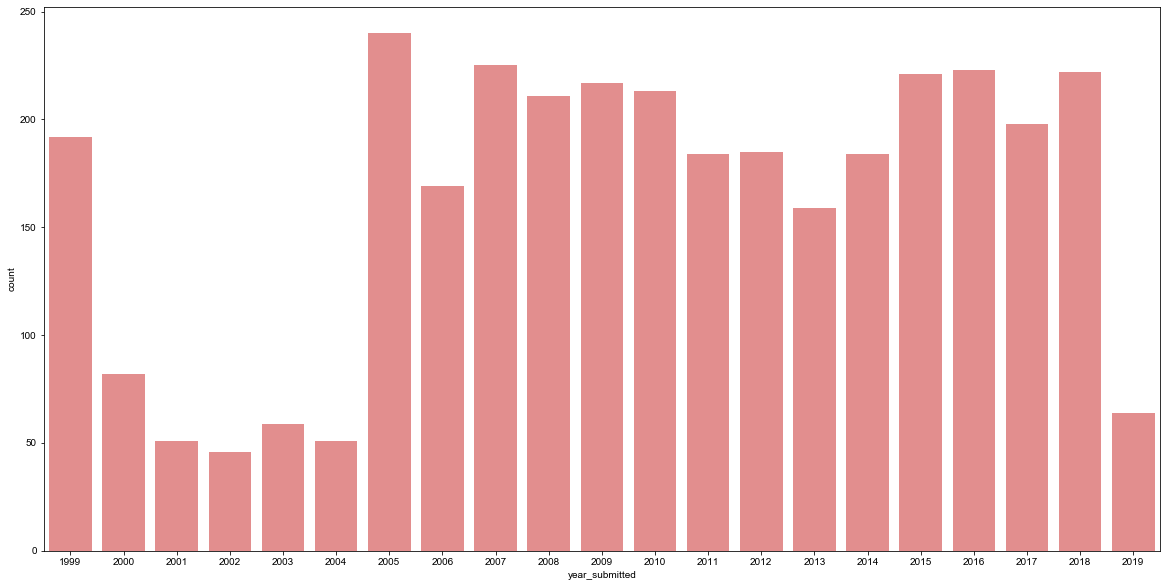

In [28]:
full_search_pandas('all_text', 'cisplatin', df)

## Test 2: Pain

Unique conditions 8890
Unique condition/mesh_terms: 1218
Unique interventon/mesh_terms: 1013
Total number of studies: 30748


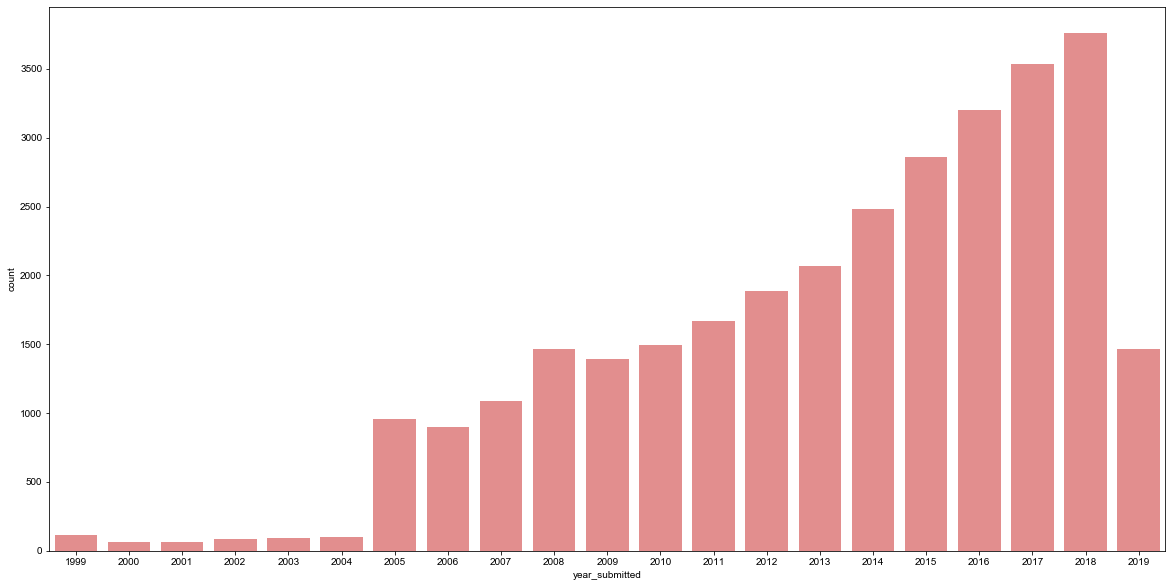

In [29]:
full_search_pandas('all_text', 'pain', df)

## Test 3: Specific drug

In [159]:
full_search_pandas('all_text', 'calquence', df)

Unique conditions 0
Unique condition/mesh_terms: 0
Unique interventon/mesh_terms: 0
Total number of studies: 0
min() arg is an empty sequence
No results


## Test 4: Pipeline

Unique conditions 1151
Unique condition/mesh_terms: 291
Unique interventon/mesh_terms: 284
Total number of studies: 2973


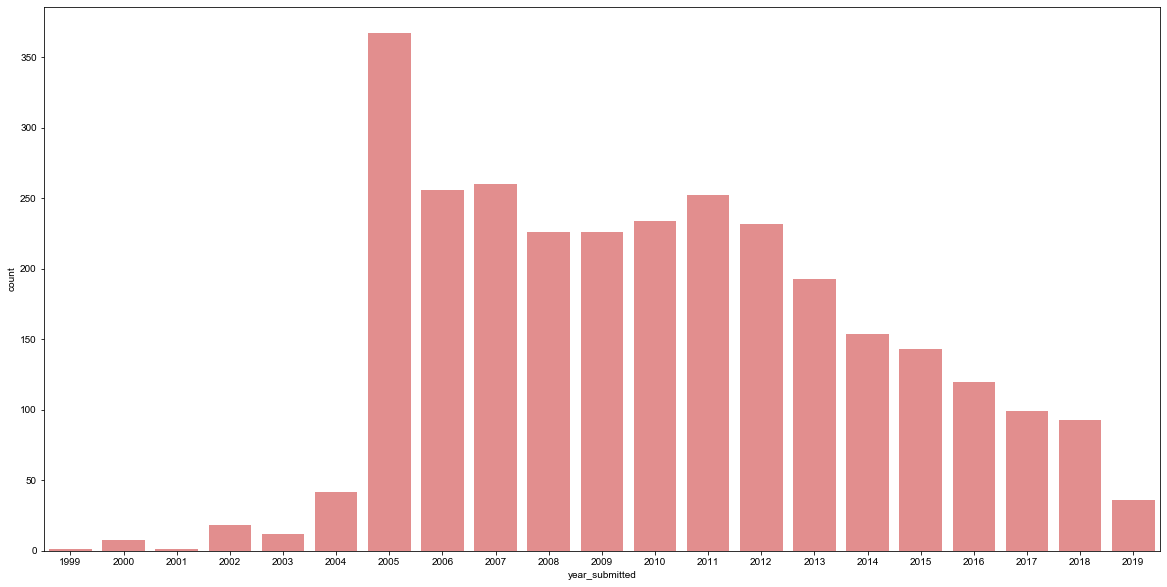

In [31]:
full_search_pandas('all_text', 'Novartis', df)

## Aggregating data by two elements

In [157]:
#Function

def search_aggregate(df, term, colum1, colum2):
    term = term.lower()
    try:
        term = df[(df['all_text'].str.contains(term, regex=False))]
        term_grouped = term.groupby([colum1, colum2])['nct_id'].count().reset_index()

        # Context for term searched
        print('Unique conditions {}'.format(term.condition.nunique()))
        print('Total number of studies: {}'.format(len(term)))

        #Chart: term over years
        sns.countplot(x=colum2, color='lightcoral', data=term)
    
    except ValueError as e:
        print(e)
        print('No results')
        pass
        
    except KeyError as e:
        print(e)
        print('No results')
        pass
        
    return term_grouped.sort_values(['nct_id'], ascending=False).head()

Unique conditions 1151
Total number of studies: 2973


,year_submitted,overall_status,nct_id
8,2005,Completed,339
20,2007,Completed,227
13,2006,Completed,226
26,2008,Completed,203
45,2011,Completed,198


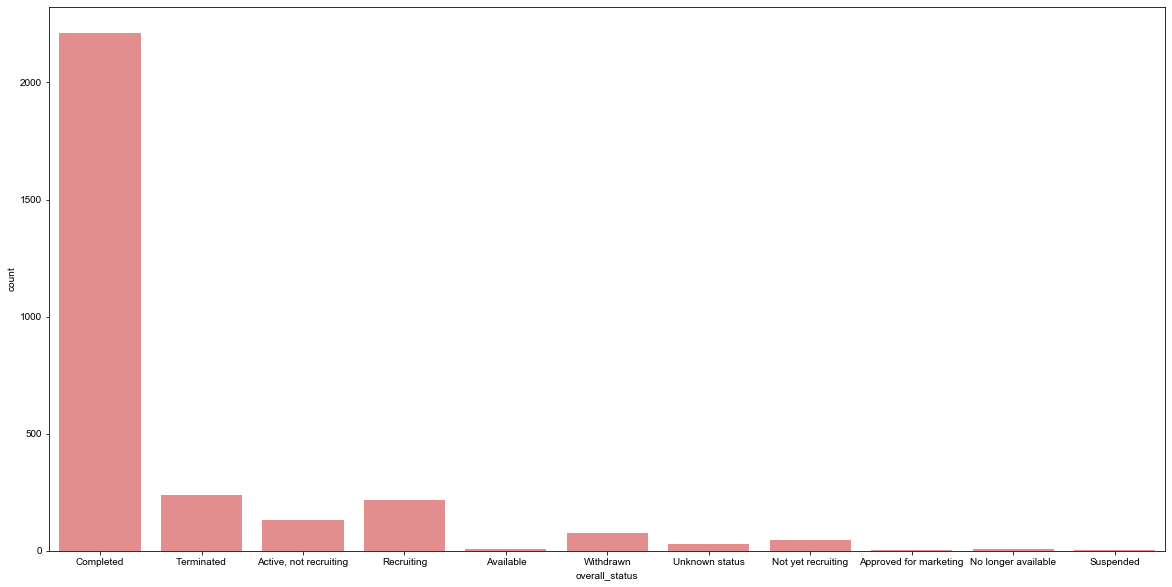

In [158]:
search_aggregate(df,'novartis', 'year_submitted', 'overall_status')

## Machine Learning workflow
- Normalization: lemmatization, and stop-word removal
- TD-IDF by context
- Link: http://kavita-ganesan.com/extracting-keywords-from-text-tfidf/

In [ ]:
# CountVectorizer